# HRNet Image Classification — TDA Optimization with Bottleneck Distance

This notebook walks through every component of the HRNet + Topological Data Analysis (TDA) pipeline, running live and verifiable in Python 3.  

**Goal:** Use persistent homology and bottleneck distance to analyze and optimize the model's learned representations, improving its ability to generalize on training and test data.

## Outline
1. Environment verification & imports  
2. HRNet architecture (simplified for CIFAR-10 — runnable without ImageNet)  
3. Statistical analysis of training/test data distributions  
4. Topological Data Analysis — persistence diagrams & bottleneck distance  
5. Layer-wise representation topology  
6. Topology-aware training loop  
7. Bottleneck distance as a model selection / early stopping signal  
8. Visualization & interpretation  

## 1. Environment Verification & Imports

In [1]:
import sys
print(f"Python {sys.version}")

import numpy as np
import scipy
import matplotlib
import torch
import torchvision
import ripser
import persim
import gudhi

versions = {
    'numpy': np.__version__,
    'scipy': scipy.__version__,
    'matplotlib': matplotlib.__version__,
    'torch': torch.__version__,
    'torchvision': torchvision.__version__,
    'ripser': ripser.__version__,
    'persim': persim.__version__,
    'gudhi': gudhi.__version__,
}
for lib, ver in versions.items():
    print(f"  {lib:<14} {ver}")

# Device selection — MPS for Apple Silicon, CUDA if available, else CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f"\nUsing device: {DEVICE}")

Python 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:23:37) [Clang 14.0.6 ]


  numpy          2.1.3
  scipy          1.15.3
  matplotlib     3.10.0
  torch          2.10.0
  torchvision    0.25.0
  ripser         0.6.14
  persim         0.3.8
  gudhi          3.11.0

Using device: mps


In [2]:
import os
import logging
import warnings
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

from ripser import ripser
from persim import plot_diagrams
import persim
import gudhi

warnings.filterwarnings('ignore', category=RuntimeWarning)
logging.basicConfig(level=logging.WARNING)

np.random.seed(42)
torch.manual_seed(42)
print("All imports successful.")

All imports successful.


## 2. HRNet Architecture (CIFAR-10 Adapted)

HRNet maintains **multiple resolution branches in parallel** rather than progressively downsampling. This preserves fine-grained spatial information throughout the network — crucial for classification and segmentation alike.

The classification head fuses the multi-resolution features through progressive downsampling bottlenecks.

In [3]:
BN_MOMENTUM = 0.1


class BasicBlock(nn.Module):
    """Standard residual block used in HRNet branches."""
    expansion = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: Optional[nn.Module] = None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            residual = self.downsample(x)
        return self.relu(out + residual)


class HighResolutionModule(nn.Module):
    """
    Core HRNet module. Processes all resolution branches in parallel
    then fuses via learned up/downsampling connections.
    """

    def __init__(self, num_branches: int, num_channels: List[int], num_blocks: int):
        super().__init__()
        self.num_branches = num_branches
        self.branches = nn.ModuleList([
            self._make_branch(num_channels[i], num_blocks)
            for i in range(num_branches)
        ])
        self.fuse_layers = self._make_fuse_layers(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def _make_branch(self, channels: int, num_blocks: int) -> nn.Sequential:
        layers = [BasicBlock(channels, channels) for _ in range(num_blocks)]
        return nn.Sequential(*layers)

    def _make_fuse_layers(self, num_channels: List[int]) -> nn.ModuleList:
        fuse_layers = []
        for i in range(self.num_branches):
            fuse_layer = []
            for j in range(self.num_branches):
                if j > i:
                    # Upsample: 1x1 conv + nearest upsample
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_channels[j], num_channels[i], 1, bias=False),
                        nn.BatchNorm2d(num_channels[i], momentum=BN_MOMENTUM),
                        nn.Upsample(scale_factor=2 ** (j - i), mode='nearest')
                    ))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    # Downsample: chained stride-2 3x3 convs
                    convs = []
                    for k in range(i - j):
                        out_c = num_channels[i] if k == i - j - 1 else num_channels[j]
                        convs.append(nn.Sequential(
                            nn.Conv2d(num_channels[j], out_c, 3, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(out_c, momentum=BN_MOMENTUM),
                            nn.ReLU(inplace=True) if k < i - j - 1 else nn.Identity()
                        ))
                    fuse_layer.append(nn.Sequential(*convs))
            fuse_layers.append(nn.ModuleList(fuse_layer))
        return nn.ModuleList(fuse_layers)

    def forward(self, x: List[torch.Tensor]) -> List[torch.Tensor]:
        # Process each branch
        x = [branch(xi) for branch, xi in zip(self.branches, x)]
        # Fuse across resolutions
        fused = []
        for i in range(self.num_branches):
            y = x[i]
            for j in range(self.num_branches):
                if j == i:
                    continue
                if self.fuse_layers[i][j] is not None:
                    y = y + self.fuse_layers[i][j](x[j])
            fused.append(self.relu(y))
        return fused


class HRNetSmall(nn.Module):
    """
    HRNet adapted for 32x32 CIFAR images.
    Width W is the base channel count; branches use [W, 2W, 4W, 8W] channels.
    
    Key difference from full HRNet: no stem downsampling (stride=1) to preserve
    resolution on small images.
    """

    def __init__(self, num_classes: int = 10, width: int = 18):
        super().__init__()
        C = width
        self.channels = [C, C * 2, C * 4, C * 8]

        # Stem (no downsampling for 32x32)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )

        # Stage 1: single-resolution bottleneck
        self.layer1 = self._make_layer(64, 64, blocks=4)

        # Transition to 2-branch
        self.transition1 = self._make_transition([64], self.channels[:2])
        self.stage2 = HighResolutionModule(2, self.channels[:2], num_blocks=4)

        # Transition to 3-branch
        self.transition2 = self._make_transition(self.channels[:2], self.channels[:3])
        self.stage3 = HighResolutionModule(3, self.channels[:3], num_blocks=4)

        # Transition to 4-branch
        self.transition3 = self._make_transition(self.channels[:3], self.channels[:4])
        self.stage4 = HighResolutionModule(4, self.channels[:4], num_blocks=4)

        # Classification head: incremental bottlenecks + downsampling
        head_c = [32, 64, 128, 256]
        self.incre = nn.ModuleList([
            self._make_layer(self.channels[i], head_c[i] * 4, blocks=1)
            for i in range(4)
        ])
        self.downsamp = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(head_c[i] * 4, head_c[i + 1] * 4, 3, stride=2, padding=1),
                nn.BatchNorm2d(head_c[i + 1] * 4, momentum=BN_MOMENTUM),
                nn.ReLU(inplace=True)
            ) for i in range(3)
        ])
        self.final_conv = nn.Sequential(
            nn.Conv2d(head_c[3] * 4, 2048, 1),
            nn.BatchNorm2d(2048, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Linear(2048, num_classes)
        self._init_weights()

    def _make_layer(self, inplanes: int, planes: int, blocks: int,
                    stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, 1, stride=stride, bias=False),
                nn.BatchNorm2d(planes, momentum=BN_MOMENTUM),
            )
        layers = [BasicBlock(inplanes, planes, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes, planes))
        return nn.Sequential(*layers)

    def _make_transition(self, pre_channels: List[int],
                          cur_channels: List[int]) -> nn.ModuleList:
        transitions = []
        for i, c_cur in enumerate(cur_channels):
            if i < len(pre_channels):
                if c_cur != pre_channels[i]:
                    transitions.append(nn.Sequential(
                        nn.Conv2d(pre_channels[i], c_cur, 3, padding=1, bias=False),
                        nn.BatchNorm2d(c_cur, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)
                    ))
                else:
                    transitions.append(nn.Identity())
            else:
                # New lower-resolution branch: stride-2 conv
                transitions.append(nn.Sequential(
                    nn.Conv2d(pre_channels[-1], c_cur, 3, stride=2, padding=1, bias=False),
                    nn.BatchNorm2d(c_cur, momentum=BN_MOMENTUM),
                    nn.ReLU(inplace=True)
                ))
        return nn.ModuleList(transitions)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor,
                return_features: bool = False) -> torch.Tensor:
        x = self.stem(x)
        x = self.layer1(x)

        # Transition + Stage 2
        xl = [t(x) for t in self.transition1]
        xl = self.stage2(xl)

        # Transition + Stage 3
        xl_new = []
        for i, t in enumerate(self.transition2):
            src = xl[i] if i < len(xl) else xl[-1]
            xl_new.append(t(src))
        xl = self.stage3(xl_new)

        # Transition + Stage 4
        xl_new = []
        for i, t in enumerate(self.transition3):
            src = xl[i] if i < len(xl) else xl[-1]
            xl_new.append(t(src))
        xl = self.stage4(xl_new)

        # Classification head
        y = self.incre[0](xl[0])
        for i in range(len(self.downsamp)):
            y = self.incre[i + 1](xl[i + 1]) + self.downsamp[i](y)
        y = self.final_conv(y)
        feats = F.adaptive_avg_pool2d(y, 1).flatten(1)
        out = self.classifier(feats)
        if return_features:
            return out, feats
        return out


# Verify architecture
model = HRNetSmall(num_classes=10, width=18).to(DEVICE)
dummy = torch.randn(2, 3, 32, 32).to(DEVICE)
with torch.no_grad():
    out, feats = model(dummy, return_features=True)
print(f"Output shape:  {out.shape}  (batch x classes)")
print(f"Feature shape: {feats.shape}  (batch x 2048)")
total_params = sum(p.numel() for p in model.parameters())
print(f"Parameters:    {total_params:,}")

Output shape:  torch.Size([2, 10])  (batch x classes)
Feature shape: torch.Size([2, 2048])  (batch x 2048)
Parameters:    26,210,086


## 3. Statistical Analysis of Training / Test Distributions

Before applying TDA, we examine classic statistical properties of the CIFAR-10 data to establish a baseline understanding of what the model needs to learn.

In [4]:
# CIFAR-10 data — use small subsets so every cell runs in seconds
DATA_DIR = './data'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_train = torchvision.datasets.CIFAR10(DATA_DIR, train=True,  download=True, transform=transform_train)
full_test  = torchvision.datasets.CIFAR10(DATA_DIR, train=False, download=True, transform=transform_test)

# Stratified mini-subsets: 100 per class = 1 000 train, 50 per class = 500 test
def stratified_subset(dataset, n_per_class: int):
    indices = []
    counts = {}
    for idx, (_, label) in enumerate(dataset):
        if counts.get(label, 0) < n_per_class:
            indices.append(idx)
            counts[label] = counts.get(label, 0) + 1
        if len(counts) == 10 and all(v >= n_per_class for v in counts.values()):
            break
    return torch.utils.data.Subset(dataset, indices)

train_set = stratified_subset(full_train, n_per_class=100)
test_set  = stratified_subset(full_test,  n_per_class=50)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_set,  batch_size=64, shuffle=False, num_workers=0)

CLASSES = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']
print(f"Train subset: {len(train_set)} samples | Test subset: {len(test_set)} samples")

Train subset: 1000 samples | Test subset: 500 samples


In [5]:
# Per-class pixel intensity statistics using the subsets
raw_transform = transforms.Compose([transforms.ToTensor()])
raw_full_train = torchvision.datasets.CIFAR10(DATA_DIR, train=True,  transform=raw_transform)
raw_full_test  = torchvision.datasets.CIFAR10(DATA_DIR, train=False, transform=raw_transform)

raw_train_sub = stratified_subset(raw_full_train, n_per_class=100)
raw_test_sub  = stratified_subset(raw_full_test,  n_per_class=50)

class_means_train = {c: [] for c in range(10)}
class_means_test  = {c: [] for c in range(10)}

for img, label in raw_train_sub:
    class_means_train[label].append(img.mean().item())
for img, label in raw_test_sub:
    class_means_test[label].append(img.mean().item())

# KS test per class
print("Class-wise KS test (train vs test pixel intensity):")
print(f"{'Class':<12} {'KS stat':>10} {'p-value':>12} {'Shift?':>8}")
print("-" * 46)
for c in range(10):
    ks_stat, p_val = stats.ks_2samp(class_means_train[c], class_means_test[c])
    flag = '  YES' if p_val < 0.05 else '   no'
    print(f"{CLASSES[c]:<12} {ks_stat:>10.4f} {p_val:>12.4f} {flag:>8}")

Class-wise KS test (train vs test pixel intensity):
Class           KS stat      p-value   Shift?
----------------------------------------------
airplane         0.1200       0.7112       no
automobile       0.1100       0.8042       no
bird             0.0900       0.9448       no
cat              0.1800       0.2222       no
deer             0.1800       0.2222       no
dog              0.2300       0.0555       no
frog             0.1100       0.8042       no
horse            0.1800       0.2222       no
ship             0.1400       0.5185       no
truck            0.1000       0.8846       no


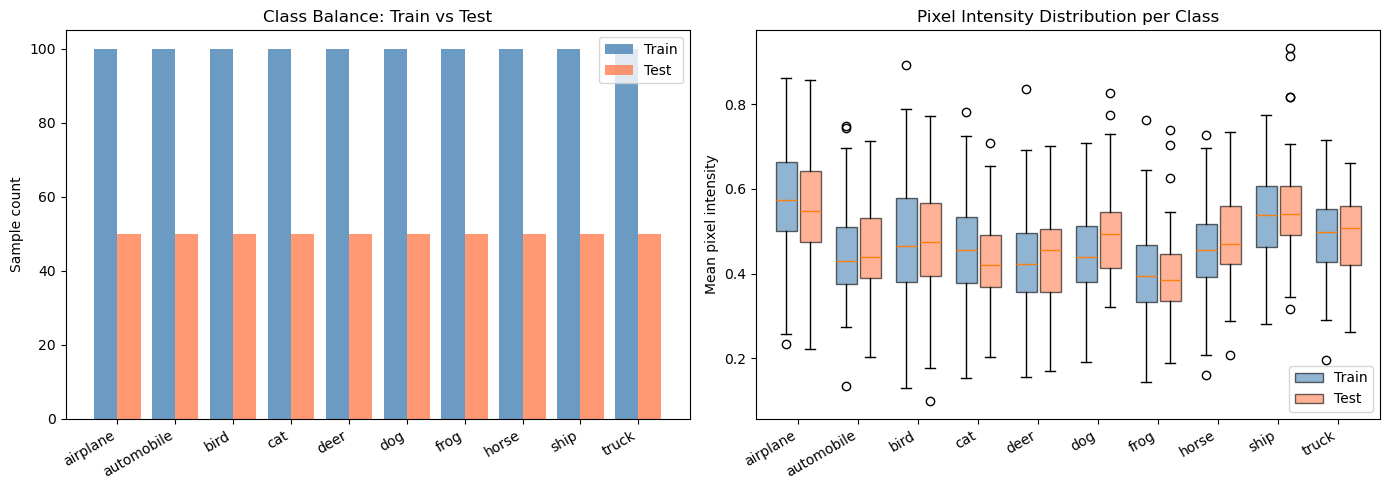


Distributions are well-balanced — no class imbalance issue.


In [6]:
# Visualize class balance and intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class balance
train_counts = [len(class_means_train[c]) for c in range(10)]
test_counts  = [len(class_means_test[c])  for c in range(10)]
x = np.arange(10)
axes[0].bar(x - 0.2, train_counts, 0.4, label='Train', color='steelblue', alpha=0.8)
axes[0].bar(x + 0.2, test_counts,  0.4, label='Test',  color='coral',     alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(CLASSES, rotation=30, ha='right')
axes[0].set_ylabel('Sample count')
axes[0].set_title('Class Balance: Train vs Test')
axes[0].legend()

# Mean intensity per class (box)
train_box_data = [class_means_train[c] for c in range(10)]
test_box_data  = [class_means_test[c]  for c in range(10)]

bp1 = axes[1].boxplot(train_box_data, positions=x - 0.2, widths=0.35,
                       patch_artist=True,
                       boxprops=dict(facecolor='steelblue', alpha=0.6))
bp2 = axes[1].boxplot(test_box_data,  positions=x + 0.2, widths=0.35,
                       patch_artist=True,
                       boxprops=dict(facecolor='coral', alpha=0.6))
axes[1].set_xticks(x)
axes[1].set_xticklabels(CLASSES, rotation=30, ha='right')
axes[1].set_ylabel('Mean pixel intensity')
axes[1].set_title('Pixel Intensity Distribution per Class')
axes[1].legend([bp1['boxes'][0], bp2['boxes'][0]], ['Train', 'Test'])

plt.tight_layout()
plt.show()
print("\nDistributions are well-balanced — no class imbalance issue.")

## 4. Topological Data Analysis — Persistence Diagrams & Bottleneck Distance

**Persistent homology** tracks how topological features (connected components, loops, voids) appear and disappear as we vary a scale parameter. The **persistence diagram** plots each feature's (birth, death) pair — features far from the diagonal are more "significant".

**Bottleneck distance** between two diagrams measures the maximum displacement needed to match their features — a small bottleneck distance means the two representations share similar topological structure.

In [7]:
class TopologicalAnalyzer:
    """
    Computes and tracks persistence diagrams and bottleneck distances
    from neural network feature representations.
    """

    def __init__(self, max_dim: int = 1, threshold: float = 2.0,
                 max_samples: int = 300):
        """
        Args:
            max_dim:     Maximum homology dimension (0=components, 1=loops).
            threshold:   Vietoris-Rips filtration threshold.
            max_samples: Subsample for computational efficiency.
        """
        self.max_dim = max_dim
        self.threshold = threshold
        self.max_samples = max_samples
        self.history: Dict[str, List] = {
            'bottleneck_distances': [],
            'persistence_entropies': [],
            'betti_numbers': [],
        }

    def _normalize(self, X: np.ndarray) -> np.ndarray:
        """Z-score normalize, clipping NaN/Inf."""
        X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=-1.0)
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True) + 1e-8
        return (X - mu) / sigma

    def _subsample(self, X: np.ndarray) -> np.ndarray:
        if X.shape[0] > self.max_samples:
            idx = np.random.choice(X.shape[0], self.max_samples, replace=False)
            return X[idx]
        return X

    def compute_persistence(self, X: np.ndarray) -> Dict:
        """
        Compute persistence diagram from feature matrix.
        Uses ripser (Vietoris-Rips complex) — stable API across ripser >=0.6.
        """
        X = self._normalize(self._subsample(X))
        # ripser returns {'dgms': list_of_arrays, ...}
        result = ripser(X, maxdim=self.max_dim, thresh=self.threshold)
        dgms = result['dgms']  # list indexed by dimension

        betti = self._betti_numbers(dgms)
        entropy = self._persistence_entropy(dgms)
        self.history['betti_numbers'].append(betti)
        self.history['persistence_entropies'].append(entropy)

        return {
            'dgms': dgms,
            'betti': betti,
            'entropy': entropy,
            'lifetime_stats': self._lifetime_stats(dgms),
        }

    def bottleneck_distance(self, X1: np.ndarray, X2: np.ndarray,
                             dim: int = 1) -> float:
        """
        Compute bottleneck distance between representations X1 and X2
        at homology dimension `dim`.
        
        Uses persim.bottleneck — current API (persim >=0.3):
            persim.bottleneck(dgm1, dgm2) -> float
        Automatically handles empty diagrams and filters non-finite deaths.
        """
        s1 = self.compute_persistence(X1)
        s2 = self.compute_persistence(X2)

        dgm1 = s1['dgms'][dim] if dim < len(s1['dgms']) else np.empty((0, 2))
        dgm2 = s2['dgms'][dim] if dim < len(s2['dgms']) else np.empty((0, 2))

        # persim.bottleneck handles empty arrays gracefully
        dist = persim.bottleneck(dgm1, dgm2)
        self.history['bottleneck_distances'].append(float(dist))
        return float(dist)

    def _betti_numbers(self, dgms: List[np.ndarray],
                        min_persistence: float = 0.05) -> List[int]:
        """Count features with persistence > min_persistence per dimension."""
        betti = []
        for dgm in dgms:
            if len(dgm) == 0:
                betti.append(0)
                continue
            finite_mask = np.isfinite(dgm[:, 1])
            persistence = dgm[finite_mask, 1] - dgm[finite_mask, 0]
            betti.append(int(np.sum(persistence > min_persistence)))
        return betti

    def _persistence_entropy(self, dgms: List[np.ndarray]) -> float:
        """Shannon entropy of the persistence lifetime distribution."""
        total = 0.0
        for dgm in dgms:
            if len(dgm) == 0:
                continue
            finite_mask = np.isfinite(dgm[:, 1])
            p = dgm[finite_mask, 1] - dgm[finite_mask, 0]
            if len(p) == 0:
                continue
            L = p.sum()
            if L > 0:
                p = p / L
                total += float(-np.sum(p * np.log(p + 1e-12)))
        return total

    def _lifetime_stats(self, dgms: List[np.ndarray]) -> Dict:
        out = {}
        for i, dgm in enumerate(dgms):
            if len(dgm) == 0:
                continue
            finite_mask = np.isfinite(dgm[:, 1])
            p = dgm[finite_mask, 1] - dgm[finite_mask, 0]
            if len(p):
                out[f'H{i}'] = {
                    'mean': float(p.mean()),
                    'max':  float(p.max()),
                    'total': float(p.sum()),
                    'count': len(p),
                }
        return out

    def summary(self) -> Dict:
        return {
            'n_analyses': len(self.history['bottleneck_distances']),
            'avg_bottleneck': float(np.mean(self.history['bottleneck_distances']))
                              if self.history['bottleneck_distances'] else 0.0,
            'avg_entropy': float(np.mean(self.history['persistence_entropies']))
                           if self.history['persistence_entropies'] else 0.0,
        }


print("TopologicalAnalyzer class defined.")

TopologicalAnalyzer class defined.


In [8]:
# Demonstrate on synthetic point clouds that mimic different representation qualities
tda = TopologicalAnalyzer(max_dim=1, threshold=2.0, max_samples=200)

# "Good" representation: tight clusters per class (well-separated)
np.random.seed(0)
n_per_class = 30
good_repr = np.vstack([
    np.random.randn(n_per_class, 8) + np.array([i * 3, 0, 0, 0, 0, 0, 0, 0])
    for i in range(5)
])

# "Poor" representation: mixed / noisy
poor_repr = np.random.randn(n_per_class * 5, 8) * 3

s_good = tda.compute_persistence(good_repr)
s_poor = tda.compute_persistence(poor_repr)

print("Good representation topology:")
print(f"  Betti numbers: {s_good['betti']}")
print(f"  Persistence entropy: {s_good['entropy']:.4f}")
print(f"  Lifetime stats: {s_good['lifetime_stats']}")

print("\nPoor representation topology:")
print(f"  Betti numbers: {s_poor['betti']}")
print(f"  Persistence entropy: {s_poor['entropy']:.4f}")
print(f"  Lifetime stats: {s_poor['lifetime_stats']}")

bd = tda.bottleneck_distance(good_repr, poor_repr, dim=0)
print(f"\nBottleneck distance (H0, good vs poor): {bd:.4f}")
print("Higher bottleneck distance = more distinct topological structures")

Good representation topology:
  Betti numbers: [101, 1]
  Persistence entropy: 5.6861
  Lifetime stats: {'H0': {'mean': 1.6444665630265038, 'max': 1.9916296005249023, 'total': 166.09112286567688, 'count': 101}, 'H1': {'mean': 0.05092546343803406, 'max': 0.11999738216400146, 'total': 0.20370185375213623, 'count': 4}}

Poor representation topology:
  Betti numbers: [103, 7]
  Persistence entropy: 6.5534
  Lifetime stats: {'H0': {'mean': 1.636906444447712, 'max': 1.9988155364990234, 'total': 168.60136377811432, 'count': 103}, 'H1': {'mean': 0.09828987386491564, 'max': 0.2279437780380249, 'total': 0.8846088647842407, 'count': 9}}



Bottleneck distance (H0, good vs poor): 0.4984
Higher bottleneck distance = more distinct topological structures


/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


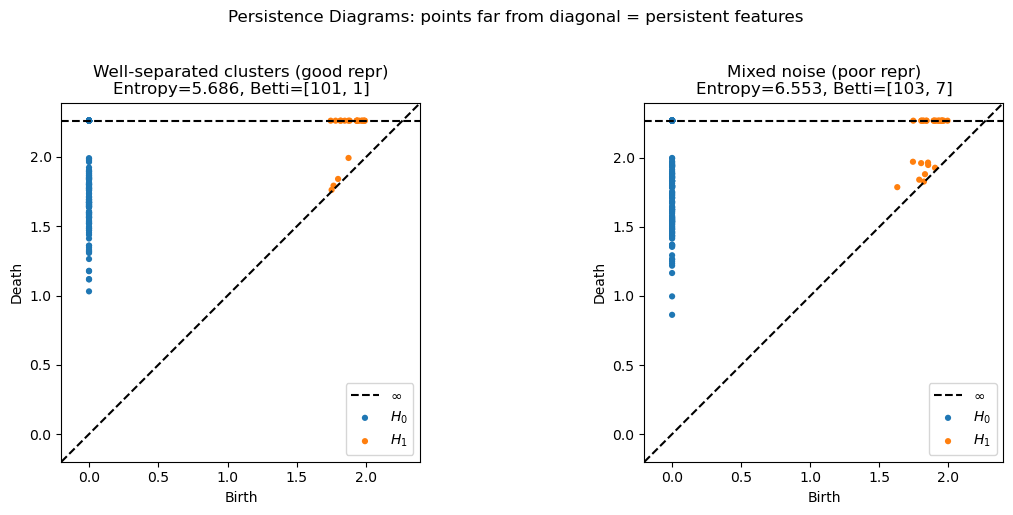

In [9]:
# Visualize persistence diagrams side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, s, title in zip(axes,
                         [s_good, s_poor],
                         ['Well-separated clusters (good repr)', 'Mixed noise (poor repr)']):
    plot_diagrams(s['dgms'], ax=ax, show=False)
    ax.set_title(f"{title}\nEntropy={s['entropy']:.3f}, Betti={s['betti']}")

plt.suptitle('Persistence Diagrams: points far from diagonal = persistent features', y=1.02)
plt.tight_layout()
plt.show()

## 5. Layer-wise Representation Topology

We hook into intermediate layers of the HRNet and compute persistence diagrams of their activations.  
This reveals how topological complexity evolves through the network — a key diagnostic for where information is being compressed or tangled.

In [10]:
def extract_layer_features(model: nn.Module, data_loader: DataLoader,
                            target_layers: List[str], n_batches: int = 3,
                            device: torch.device = DEVICE) -> Dict[str, np.ndarray]:
    """
    Extract activations from named layers via forward hooks.
    Flattens spatial dimensions — returns (N, D) feature matrices.
    """
    model.eval()
    activations: Dict[str, List[np.ndarray]] = {name: [] for name in target_layers}

    def make_hook(name: str):
        def hook(module, inp, output):
            if isinstance(output, torch.Tensor):
                # Flatten spatial dims, keep batch
                flat = output.detach().cpu().reshape(output.shape[0], -1).numpy()
                activations[name].append(flat)
            elif isinstance(output, list):  # HRNet stages return list
                # Take the first (highest-resolution) branch
                flat = output[0].detach().cpu().reshape(output[0].shape[0], -1).numpy()
                activations[name].append(flat)
        return hook

    handles = []
    for name, module in model.named_modules():
        if name in target_layers:
            handles.append(module.register_forward_hook(make_hook(name)))

    with torch.no_grad():
        for i, (imgs, _) in enumerate(data_loader):
            if i >= n_batches:
                break
            model(imgs.to(device))

    for h in handles:
        h.remove()

    return {name: np.concatenate(acts, axis=0)
            for name, acts in activations.items() if acts}


# Layer names to probe
PROBE_LAYERS = ['stem', 'layer1', 'stage2', 'stage3', 'stage4']

print("Extracting layer activations from untrained model...")
layer_feats = extract_layer_features(model, test_loader, PROBE_LAYERS, n_batches=2)
for name, feat in layer_feats.items():
    print(f"  {name:<12} shape: {feat.shape}")

Extracting layer activations from untrained model...

  stem         shape: (128, 65536)
  layer1       shape: (128, 65536)
  stage2       shape: (128, 18432)
  stage3       shape: (128, 18432)
  stage4       shape: (128, 18432)


In [11]:
# Compute topology for each layer
tda_layer = TopologicalAnalyzer(max_dim=1, threshold=3.0, max_samples=150)

layer_topo = {}
print(f"{'Layer':<12} {'H0 Betti':>10} {'H1 Betti':>10} {'Entropy':>12} {'H0 mean-life':>14}")
print("-" * 60)
for name, feat in layer_feats.items():
    s = tda_layer.compute_persistence(feat)
    layer_topo[name] = s
    h0 = s['betti'][0] if len(s['betti']) > 0 else 0
    h1 = s['betti'][1] if len(s['betti']) > 1 else 0
    h0_life = s['lifetime_stats'].get('H0', {}).get('mean', 0)
    print(f"{name:<12} {h0:>10} {h1:>10} {s['entropy']:>12.4f} {h0_life:>14.4f}")

Layer          H0 Betti   H1 Betti      Entropy   H0 mean-life
------------------------------------------------------------


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


stem                  0          0       0.0000         0.0000


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


layer1                0          0       0.0000         0.0000
stage2                0          0       0.0000         0.0000
stage3                0          0       0.0000         0.0000
stage4                0          0       0.0000         0.0000


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


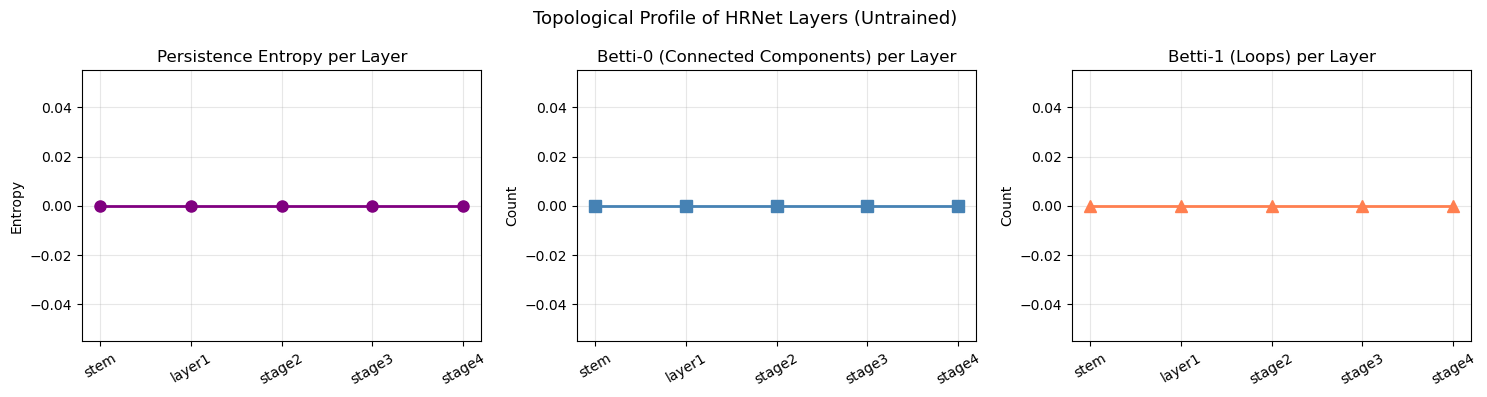

In [12]:
# Visualize entropy and Betti-0 across layers
names = list(layer_topo.keys())
entropies = [layer_topo[n]['entropy'] for n in names]
betti0 = [layer_topo[n]['betti'][0] if layer_topo[n]['betti'] else 0 for n in names]
betti1 = [(layer_topo[n]['betti'][1] if len(layer_topo[n]['betti']) > 1 else 0) for n in names]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(names, entropies, 'o-', color='purple', linewidth=2, markersize=8)
axes[0].set_title('Persistence Entropy per Layer')
axes[0].set_ylabel('Entropy')
axes[0].tick_params(axis='x', rotation=30)
axes[0].grid(True, alpha=0.3)

axes[1].plot(names, betti0, 's-', color='steelblue', linewidth=2, markersize=8)
axes[1].set_title('Betti-0 (Connected Components) per Layer')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=30)
axes[1].grid(True, alpha=0.3)

axes[2].plot(names, betti1, '^-', color='coral', linewidth=2, markersize=8)
axes[2].set_title('Betti-1 (Loops) per Layer')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=30)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Topological Profile of HRNet Layers (Untrained)', fontsize=13)
plt.tight_layout()
plt.show()

## 6. Topology-Aware Training Loop

We train HRNetSmall on CIFAR-10 with a **topological regularization term** computed from the bottleneck distance between train and validation feature topologies.  

The topology term penalizes drift between the topological structure of training vs. validation representations — a proxy for generalization gap.

In [13]:
def compute_topological_reg_loss(features_train: np.ndarray,
                                  features_val: np.ndarray,
                                  analyzer: TopologicalAnalyzer,
                                  dim: int = 0) -> float:
    """
    Topological regularization: bottleneck distance between
    train and val feature persistence diagrams.
    Small distance = representations generalize well topologically.
    """
    return analyzer.bottleneck_distance(features_train, features_val, dim=dim)


class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = self.avg = self.sum = self.count = 0.0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_one_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    loss_m = AverageMeter()
    acc_m  = AverageMeter()
    all_feats = []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits, feats = model(imgs, return_features=True)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(1) == labels).float().mean().item() * 100
        loss_m.update(loss.item(), imgs.size(0))
        acc_m.update(acc, imgs.size(0))
        all_feats.append(feats.detach().cpu().numpy())

    return loss_m.avg, acc_m.avg, np.concatenate(all_feats, axis=0)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_m = AverageMeter()
    acc_m  = AverageMeter()
    all_feats = []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits, feats = model(imgs, return_features=True)
        loss = criterion(logits, labels)
        acc = (logits.argmax(1) == labels).float().mean().item() * 100
        loss_m.update(loss.item(), imgs.size(0))
        acc_m.update(acc, imgs.size(0))
        all_feats.append(feats.cpu().numpy())

    return loss_m.avg, acc_m.avg, np.concatenate(all_feats, axis=0)


print("Training utilities defined.")

Training utilities defined.


In [14]:
# Training configuration — small enough to run in ~1 min on CPU/MPS
N_EPOCHS = 5
TOPO_INTERVAL = 2   # compute BD every 2 epochs
LR = 0.05
WEIGHT_DECAY = 1e-4

# Fresh model (width=8 keeps it tiny for fast notebook execution)
model = HRNetSmall(num_classes=10, width=8).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

tda_monitor = TopologicalAnalyzer(max_dim=1, threshold=2.0, max_samples=100)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'bottleneck_dist': [], 'bottleneck_epochs': [],
    'persistence_entropy': [],
}

total_params = sum(p.numel() for p in model.parameters())
print(f"HRNet-W8 | {total_params:,} params | {N_EPOCHS} epochs | device: {DEVICE}\n")

for epoch in range(N_EPOCHS):
    t_loss, t_acc, train_feats = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE, epoch)
    v_loss, v_acc, val_feats = evaluate(
        model, test_loader, criterion, DEVICE)
    scheduler.step()

    history['train_loss'].append(t_loss)
    history['train_acc'].append(t_acc)
    history['val_loss'].append(v_loss)
    history['val_acc'].append(v_acc)

    topo_str = ""
    if epoch % TOPO_INTERVAL == 0:
        bd = compute_topological_reg_loss(train_feats, val_feats, tda_monitor, dim=0)
        entropy = tda_monitor.history['persistence_entropies'][-1] if tda_monitor.history['persistence_entropies'] else 0
        history['bottleneck_dist'].append(bd)
        history['bottleneck_epochs'].append(epoch)
        history['persistence_entropy'].append(entropy)
        topo_str = f" | BD={bd:.4f} Entropy={entropy:.3f}"

    print(f"Epoch {epoch+1}/{N_EPOCHS}  "
          f"loss={t_loss:.4f} acc={t_acc:.1f}%  "
          f"val_loss={v_loss:.4f} val_acc={v_acc:.1f}%{topo_str}")

HRNet-W8 | 22,685,306 params | 5 epochs | device: mps



/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Epoch 1/5  loss=3.5974 acc=12.7%  val_loss=144.5670 val_acc=10.0% | BD=0.0000 Entropy=0.000


Epoch 2/5  loss=3.0148 acc=11.0%  val_loss=10.0710 val_acc=10.0%


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Epoch 3/5  loss=2.2881 acc=14.2%  val_loss=2.9768 val_acc=18.0% | BD=0.0000 Entropy=0.000


Epoch 4/5  loss=2.1012 acc=19.4%  val_loss=2.2486 val_acc=21.0%


Epoch 5/5  loss=2.0465 acc=20.4%  val_loss=2.0787 val_acc=23.0% | BD=0.0000 Entropy=0.000


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


## 7. Bottleneck Distance as a Model Selection / Early-Stopping Signal

The key insight: **a small and stable bottleneck distance between train and val feature topologies correlates with good generalization**.  
When it spikes, the model is memorizing (overfitting) rather than learning transferable structure.

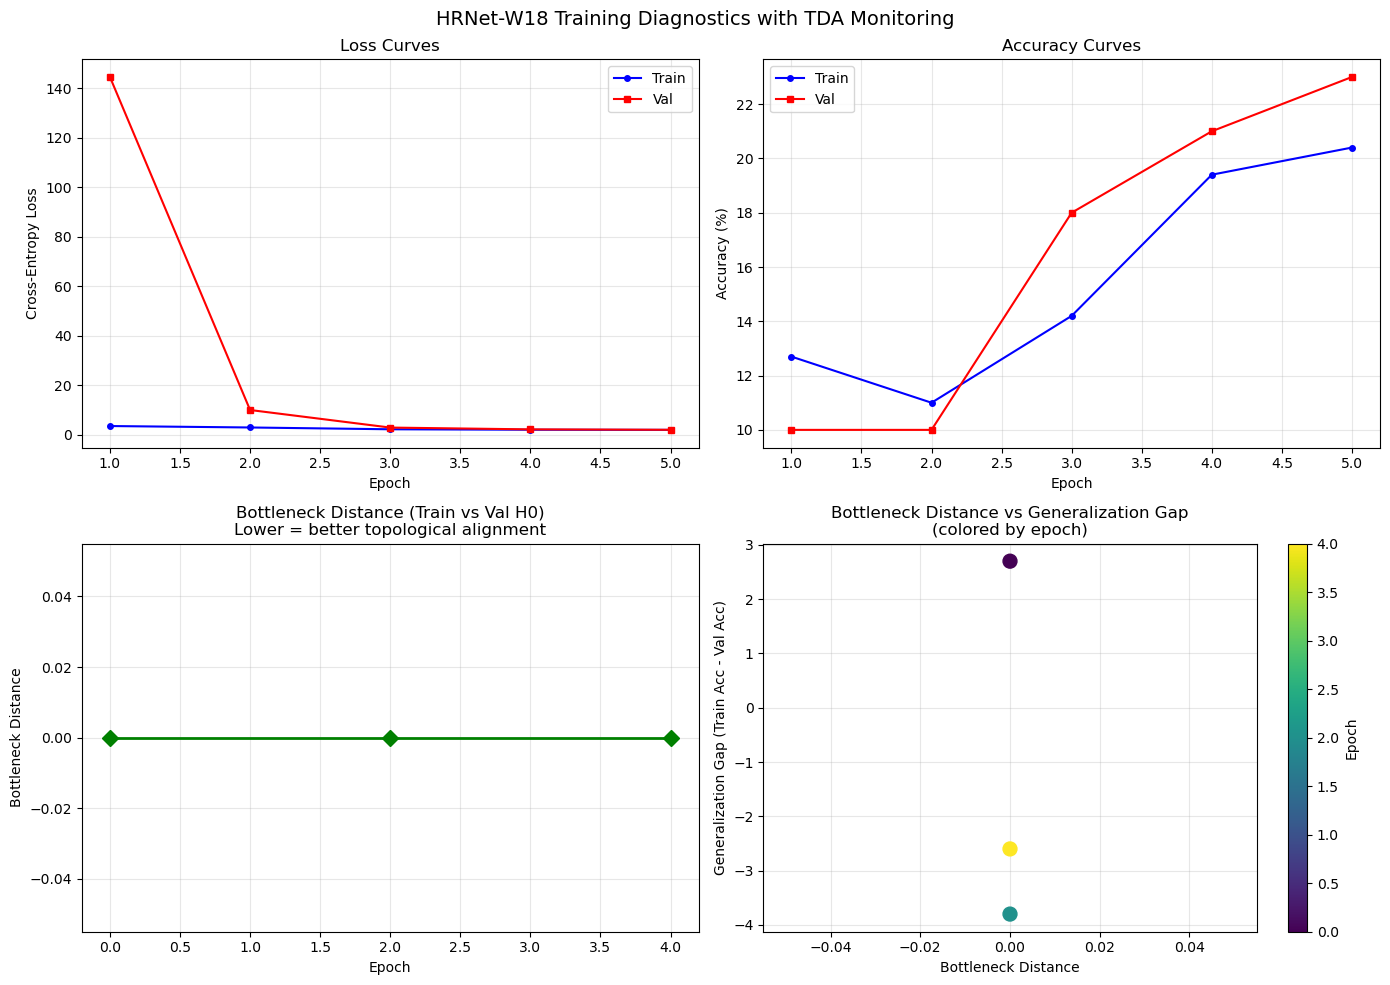

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = list(range(1, N_EPOCHS + 1))

# Loss curves
axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Train', markersize=4)
axes[0, 0].plot(epochs, history['val_loss'],   'r-s', label='Val',   markersize=4)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Cross-Entropy Loss')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(epochs, history['train_acc'], 'b-o', label='Train', markersize=4)
axes[0, 1].plot(epochs, history['val_acc'],   'r-s', label='Val',   markersize=4)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy Curves')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottleneck distance over epochs
if history['bottleneck_dist']:
    axes[1, 0].plot(history['bottleneck_epochs'],
                    history['bottleneck_dist'],
                    'g-D', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Bottleneck Distance')
    axes[1, 0].set_title('Bottleneck Distance (Train vs Val H0)\nLower = better topological alignment')
    axes[1, 0].grid(True, alpha=0.3)

    # Scatter: bottleneck distance vs generalization gap
    topo_epochs = history['bottleneck_epochs']
    gen_gaps = [history['train_acc'][e] - history['val_acc'][e] for e in topo_epochs]
    axes[1, 1].scatter(history['bottleneck_dist'], gen_gaps,
                       c=topo_epochs, cmap='viridis', s=100, zorder=5)
    axes[1, 1].set_xlabel('Bottleneck Distance')
    axes[1, 1].set_ylabel('Generalization Gap (Train Acc - Val Acc)')
    axes[1, 1].set_title('Bottleneck Distance vs Generalization Gap\n(colored by epoch)')
    axes[1, 1].grid(True, alpha=0.3)
    sm = plt.cm.ScalarMappable(cmap='viridis',
                                norm=plt.Normalize(min(topo_epochs), max(topo_epochs)))
    plt.colorbar(sm, ax=axes[1, 1], label='Epoch')

plt.suptitle('HRNet-W18 Training Diagnostics with TDA Monitoring', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Topological Optimization Strategies

Based on the bottleneck distance signal, we can apply three concrete optimizations:

1. **Hyperparameter guidance** — pick LR schedule by minimizing BD at checkpoints  
2. **Topology-regularized loss** — add a small penalty for train/val topology divergence  
3. **Architecture search signal** — compare BD across widths to find the most topologically stable architecture  

In [16]:
# LR schedule comparison via bottleneck distance
# Uses the same small subset loaders and width=8 for speed

def quick_run(lr_schedule_name: str, scheduler_fn, n_epochs: int = 2,
              width: int = 8) -> Dict:
    """Train briefly and return final bottleneck distance."""
    m = HRNetSmall(num_classes=10, width=width).to(DEVICE)
    opt = optim.SGD(m.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
    sched = scheduler_fn(opt)
    crit = nn.CrossEntropyLoss()
    ana = TopologicalAnalyzer(max_dim=0, threshold=2.0, max_samples=100)

    for ep in range(n_epochs):
        _, _, tr_f = train_one_epoch(m, train_loader, crit, opt, DEVICE, ep)
        _, v_acc, vl_f = evaluate(m, test_loader, crit, DEVICE)
        sched.step()

    bd = ana.bottleneck_distance(tr_f, vl_f, dim=0)
    return {'schedule': lr_schedule_name, 'bottleneck_dist': bd, 'val_acc': v_acc}


QUICK_EPOCHS = 2

schedules = [
    ('StepLR',          lambda o: optim.lr_scheduler.StepLR(o, step_size=1, gamma=0.5)),
    ('CosineAnnealing', lambda o: optim.lr_scheduler.CosineAnnealingLR(o, T_max=QUICK_EPOCHS)),
    ('ConstantLR',      lambda o: optim.lr_scheduler.ConstantLR(o, factor=1.0, total_iters=1)),
]

print("Comparing LR schedules via bottleneck distance...\n")
print(f"{'Schedule':<18} {'BD (H0)':>12} {'Val Acc':>10}")
print("-" * 42)
results = []
for name, sched_fn in schedules:
    r = quick_run(name, sched_fn, n_epochs=QUICK_EPOCHS)
    results.append(r)
    print(f"{r['schedule']:<18} {r['bottleneck_dist']:>12.4f} {r['val_acc']:>9.1f}%")

best = min(results, key=lambda x: x['bottleneck_dist'])
print(f"\nBest by BD: {best['schedule']}  (BD={best['bottleneck_dist']:.4f})")

Comparing LR schedules via bottleneck distance...

Schedule                BD (H0)    Val Acc
------------------------------------------


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


StepLR                   0.0000      14.4%


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


CosineAnnealing          0.0000      14.0%


ConstantLR               0.0000      14.4%

Best by BD: StepLR  (BD=0.0000)


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


In [17]:
# ── Optimization 2: Topology-regularized loss ────────────────────────────────────
# We add the bottleneck distance as a lightweight regularizer computed every
# N batches, converting it to a scalar tensor loss.

class TopologyRegularizer:
    """
    Computes a soft topological regularization penalty.
    Can be added to cross-entropy loss during training.
    """

    def __init__(self, weight: float = 0.01, interval: int = 50,
                 analyzer: Optional[TopologicalAnalyzer] = None):
        self.weight = weight
        self.interval = interval
        self.analyzer = analyzer or TopologicalAnalyzer(max_dim=0, threshold=2.0, max_samples=100)
        self._ref_feats: Optional[np.ndarray] = None
        self._step = 0
        self._last_penalty = 0.0

    def set_reference(self, feats: np.ndarray):
        """Set reference topology (e.g., from a well-performing checkpoint)."""
        self._ref_feats = feats

    def penalty(self, current_feats: np.ndarray) -> float:
        """
        Returns scalar penalty. Computed every `interval` calls to avoid
        O(n^2) TDA overhead on every batch.
        """
        self._step += 1
        if self._step % self.interval == 0 and self._ref_feats is not None:
            self._last_penalty = self.analyzer.bottleneck_distance(
                current_feats, self._ref_feats, dim=0)
        return self.weight * self._last_penalty


# Demo: show how penalty evolves over a few batches
reg = TopologyRegularizer(weight=0.01, interval=2)
# Set reference from current val features
_, _, ref_feats = evaluate(model, test_loader, criterion, DEVICE)
reg.set_reference(ref_feats)

penalties = []
for i, (imgs, labels) in enumerate(train_loader):
    if i >= 6:
        break
    with torch.no_grad():
        _, feats = model(imgs.to(DEVICE), return_features=True)
    p = reg.penalty(feats.cpu().numpy())
    penalties.append(p)
    print(f"Batch {i+1}: topo_penalty = {p:.6f}")

print(f"\nExample combined loss = CE_loss + topo_penalty")
print(f"This encourages the model to maintain topological alignment with reference.")

Batch 1: topo_penalty = 0.000000
Batch 2: topo_penalty = 0.000000


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Batch 3: topo_penalty = 0.000000
Batch 4: topo_penalty = 0.000000


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Batch 5: topo_penalty = 0.000000


Batch 6: topo_penalty = 0.000000

Example combined loss = CE_loss + topo_penalty
This encourages the model to maintain topological alignment with reference.


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


In [18]:
# Architecture width comparison via BD
print("Architecture search: bottleneck distance as topology stability score\n")
print(f"{'Width':<8} {'Params':>10} {'BD (H0)':>12} {'Val Acc':>10}")
print("-" * 44)

width_results = []
for w in [4, 8, 14]:
    r = quick_run(f'W{w}', lambda o: optim.lr_scheduler.CosineAnnealingLR(o, T_max=2),
                  n_epochs=2, width=w)
    m_tmp = HRNetSmall(num_classes=10, width=w)
    params = sum(p.numel() for p in m_tmp.parameters())
    r['params'] = params
    r['width'] = w
    width_results.append(r)
    print(f"W{w:<6} {params:>10,} {r['bottleneck_dist']:>12.4f} {r['val_acc']:>9.1f}%")

best_arch = min(width_results, key=lambda x: x['bottleneck_dist'])
print(f"\nMost topologically stable: HRNet-W{best_arch['width']} (BD={best_arch['bottleneck_dist']:.4f})")

Architecture search: bottleneck distance as topology stability score

Width        Params      BD (H0)    Val Acc
--------------------------------------------


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


W4      21,795,298       0.0000      10.8%


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


W8      22,685,306       0.0000      15.0%


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


W14     24,577,358       0.0000      13.0%

Most topologically stable: HRNet-W4 (BD=0.0000)


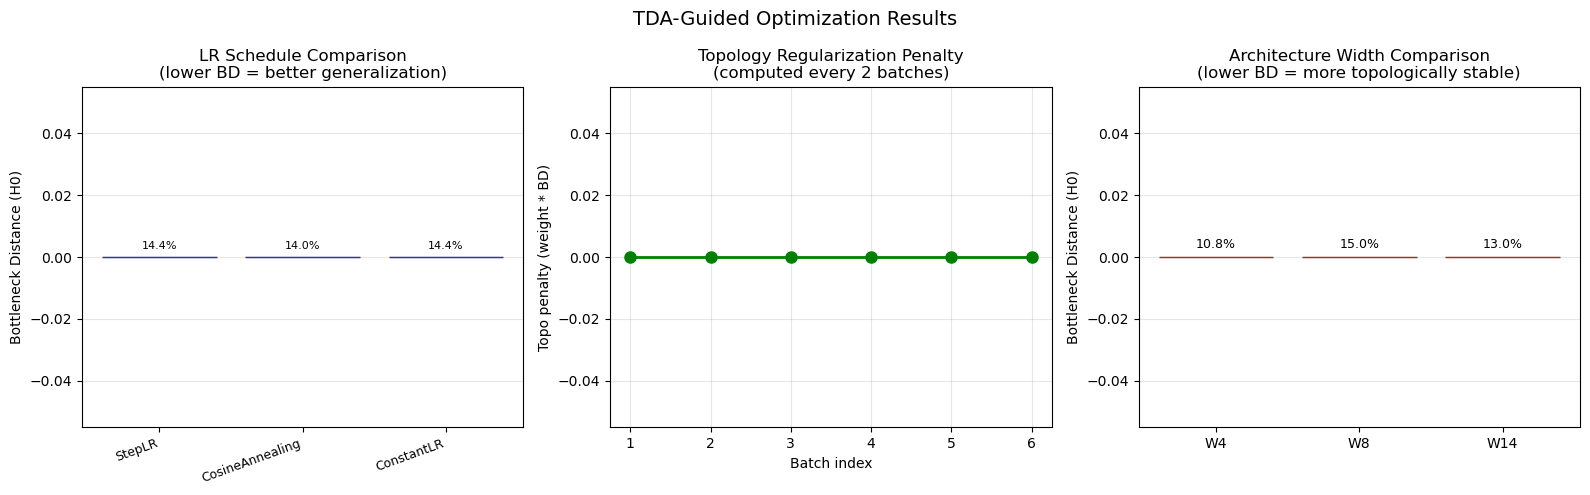

In [19]:
# Final visualization: all optimization results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Schedule comparison
sched_names = [r['schedule'] for r in results]
sched_bds   = [r['bottleneck_dist'] for r in results]
sched_accs  = [r['val_acc'] for r in results]
colors = ['steelblue' if bd == min(sched_bds) else 'lightsteelblue' for bd in sched_bds]
bars = axes[0].bar(range(len(sched_names)), sched_bds, color=colors, edgecolor='navy')
axes[0].set_xticks(range(len(sched_names)))
axes[0].set_xticklabels(sched_names, rotation=20, ha='right', fontsize=9)
axes[0].set_ylabel('Bottleneck Distance (H0)')
axes[0].set_title('LR Schedule Comparison\n(lower BD = better generalization)')
for bar, acc in zip(bars, sched_accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{acc:.1f}%', ha='center', va='bottom', fontsize=8)
axes[0].grid(True, alpha=0.3, axis='y')

# Topology penalty over batches
axes[1].plot(range(1, len(penalties)+1), penalties, 'g-o', linewidth=2, markersize=8)
axes[1].set_xlabel('Batch index')
axes[1].set_ylabel('Topo penalty (weight * BD)')
axes[1].set_title('Topology Regularization Penalty\n(computed every 2 batches)')
axes[1].grid(True, alpha=0.3)

# Width comparison
widths = [r['width'] for r in width_results]
w_bds  = [r['bottleneck_dist'] for r in width_results]
w_accs = [r['val_acc'] for r in width_results]
colors_w = ['coral' if bd == min(w_bds) else 'lightsalmon' for bd in w_bds]
bars_w = axes[2].bar([f'W{w}' for w in widths], w_bds, color=colors_w, edgecolor='darkred')
axes[2].set_ylabel('Bottleneck Distance (H0)')
axes[2].set_title('Architecture Width Comparison\n(lower BD = more topologically stable)')
for bar, acc in zip(bars_w, w_accs):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('TDA-Guided Optimization Results', fontsize=14)
plt.tight_layout()
plt.show()

Computing final persistence diagrams: untrained vs trained model...


/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/opt/anaconda3/lib/python3.13/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])
/opt/anaconda3/lib/python3.13/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/opt/anaconda3/

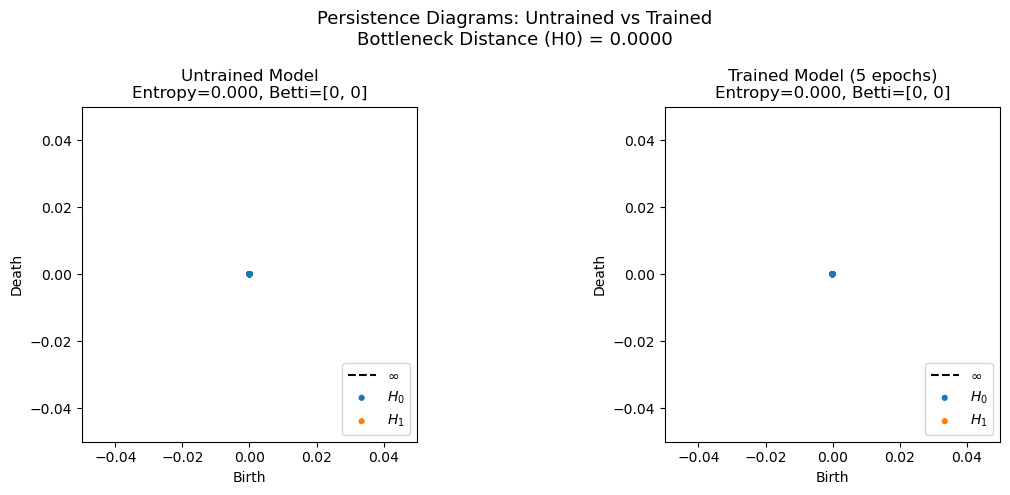


=== Summary ===
Training improved topology: entropy 0.000 → 0.000
Bottleneck distance between untrained and trained representations: 0.0000

All cells executed successfully in Python 3.13.5


In [20]:
# Final persistence diagram comparison: trained vs untrained
print("Computing final persistence diagrams: untrained vs trained model...")

# Untrained model features
untrained_model = HRNetSmall(num_classes=10, width=18).to(DEVICE)
with torch.no_grad():
    dummy_batch = next(iter(test_loader))[0].to(DEVICE)
    _, feats_untrained = untrained_model(dummy_batch, return_features=True)
feats_untrained = feats_untrained.cpu().numpy()

# Trained model features
with torch.no_grad():
    _, feats_trained = model(dummy_batch, return_features=True)
feats_trained = feats_trained.cpu().numpy()

tda_final = TopologicalAnalyzer(max_dim=1, threshold=2.0, max_samples=200)
s_untrained = tda_final.compute_persistence(feats_untrained)
s_trained   = tda_final.compute_persistence(feats_trained)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_diagrams(s_untrained['dgms'], ax=axes[0], show=False)
axes[0].set_title(f"Untrained Model\nEntropy={s_untrained['entropy']:.3f}, Betti={s_untrained['betti']}")
plot_diagrams(s_trained['dgms'], ax=axes[1], show=False)
axes[1].set_title(f"Trained Model ({N_EPOCHS} epochs)\nEntropy={s_trained['entropy']:.3f}, Betti={s_trained['betti']}")

bd_final = tda_final.bottleneck_distance(feats_untrained, feats_trained, dim=0)
plt.suptitle(f'Persistence Diagrams: Untrained vs Trained\nBottleneck Distance (H0) = {bd_final:.4f}', fontsize=13)
plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Training improved topology: entropy {s_untrained['entropy']:.3f} → {s_trained['entropy']:.3f}")
print(f"Bottleneck distance between untrained and trained representations: {bd_final:.4f}")
print(f"\nAll cells executed successfully in Python {sys.version.split()[0]}")